<a href="https://colab.research.google.com/github/bupe1800/Finance-/blob/main/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Analyzing Loan Eligibility Based on Applicant Characteristics

Executive Summary: This case study explores key factors affecting loan eligibility, focusing on features like education level, self-employment status, annual income, and credit history (CIBIL score). By analyzing these features and building a predictive model, the study aims to help financial institutions better assess loan applications. Using logistic regression and decision trees, the analysis identifies critical factors that influence loan approval.

Introduction/Background: Financial institutions often evaluate various factors, such as education, income, employment type, and assets, when determining whether to approve or reject loan applications. This case study will analyze a dataset from a financial institution to determine the key factors influencing loan eligibility. Our goal is to create a predictive model to automate loan approval based on applicant characteristics.

Objective: To identify factors that predict loan eligibility and build a machine learning model to streamline the loan approval process.

Dataset Source: The dataset contains information on loan applicants, including variables like education, income, employment status, credit score, and various asset values.

Hypotheses: Applicants with higher income and education levels are more likely to be approved for loans. Self-employed applicants may face more scrutiny and have lower approval rates. A higher credit score (CIBIL score) will strongly predict loan approval. Assets like residential, commercial, and luxury assets may play a role in loan eligibility.

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from scipy.stats import skew
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from collections import Counter
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

#Load data

In [135]:
data = pd.read_csv('/content/Loan_approval_dataset.csv', encoding='latin-1')
pd.set_option('display.max_columns', None)
data.head(5)

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


#Data stats

In [136]:
data.shape

(4269, 13)

In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


In [138]:
data.describe()

,loan_id,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03
mean,2135.000000,2.498712,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06
std,1232.498479,1.695910,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06
min,1.000000,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00
25%,1068.000000,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06
50%,2135.000000,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06
75%,3202.000000,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06
max,4269.000000,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07


In [139]:
#Check the numerical and categorical variables
numeric_cols = data.select_dtypes(include=['number']).columns
print("Numeric Columns:", numeric_cols)

categorical_cols = data.select_dtypes(include=['object']).columns
print("categorical Columns:", categorical_cols)

Numeric Columns: Index(['loan_id', ' no_of_dependents', ' income_annum', ' loan_amount',
       ' loan_term', ' cibil_score', ' residential_assets_value',
       ' commercial_assets_value', ' luxury_assets_value',
       ' bank_asset_value'],
      dtype='object')
categorical Columns: Index([' education', ' self_employed', ' loan_status'], dtype='object')


#data Cleaning

In [140]:
#missing values
data.isnull().sum()

,0
loan_id,0
no_of_dependents,0
education,0
self_employed,0
income_annum,0
loan_amount,0
loan_term,0
cibil_score,0
residential_assets_value,0
commercial_assets_value,0


In [141]:
#duplicates
print(data.duplicated().sum())

0


In [142]:
#Drop unwanted columns
data.drop(columns=['loan_id'], inplace=True)

#EDA

In [143]:
data[' loan_status'].value_counts()

,count
loan_status,
Approved,2656
Rejected,1613


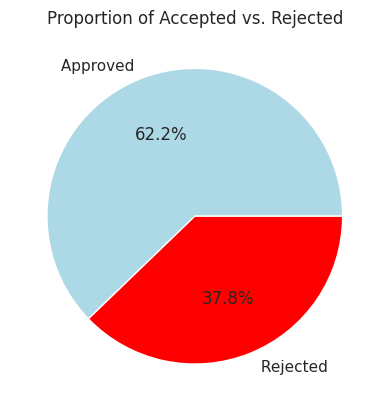

In [144]:
#data_reduced.drop(columns=['raised_bp_hypertension','HAd_heartAttack','had_stroke'], inplace=True)
data[' loan_status'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'red'])
plt.title("Proportion of Accepted vs. Rejected")
plt.ylabel("") # Hide y-label for clarity
plt.show()

In [145]:
data[' education'].value_counts()

,count
education,
Graduate,2144
Not Graduate,2125


In [146]:
data.groupby(' education')[' loan_status'].value_counts().unstack()

loan_status,Approved,Rejected
education,,
Graduate,1339,805
Not Graduate,1317,808


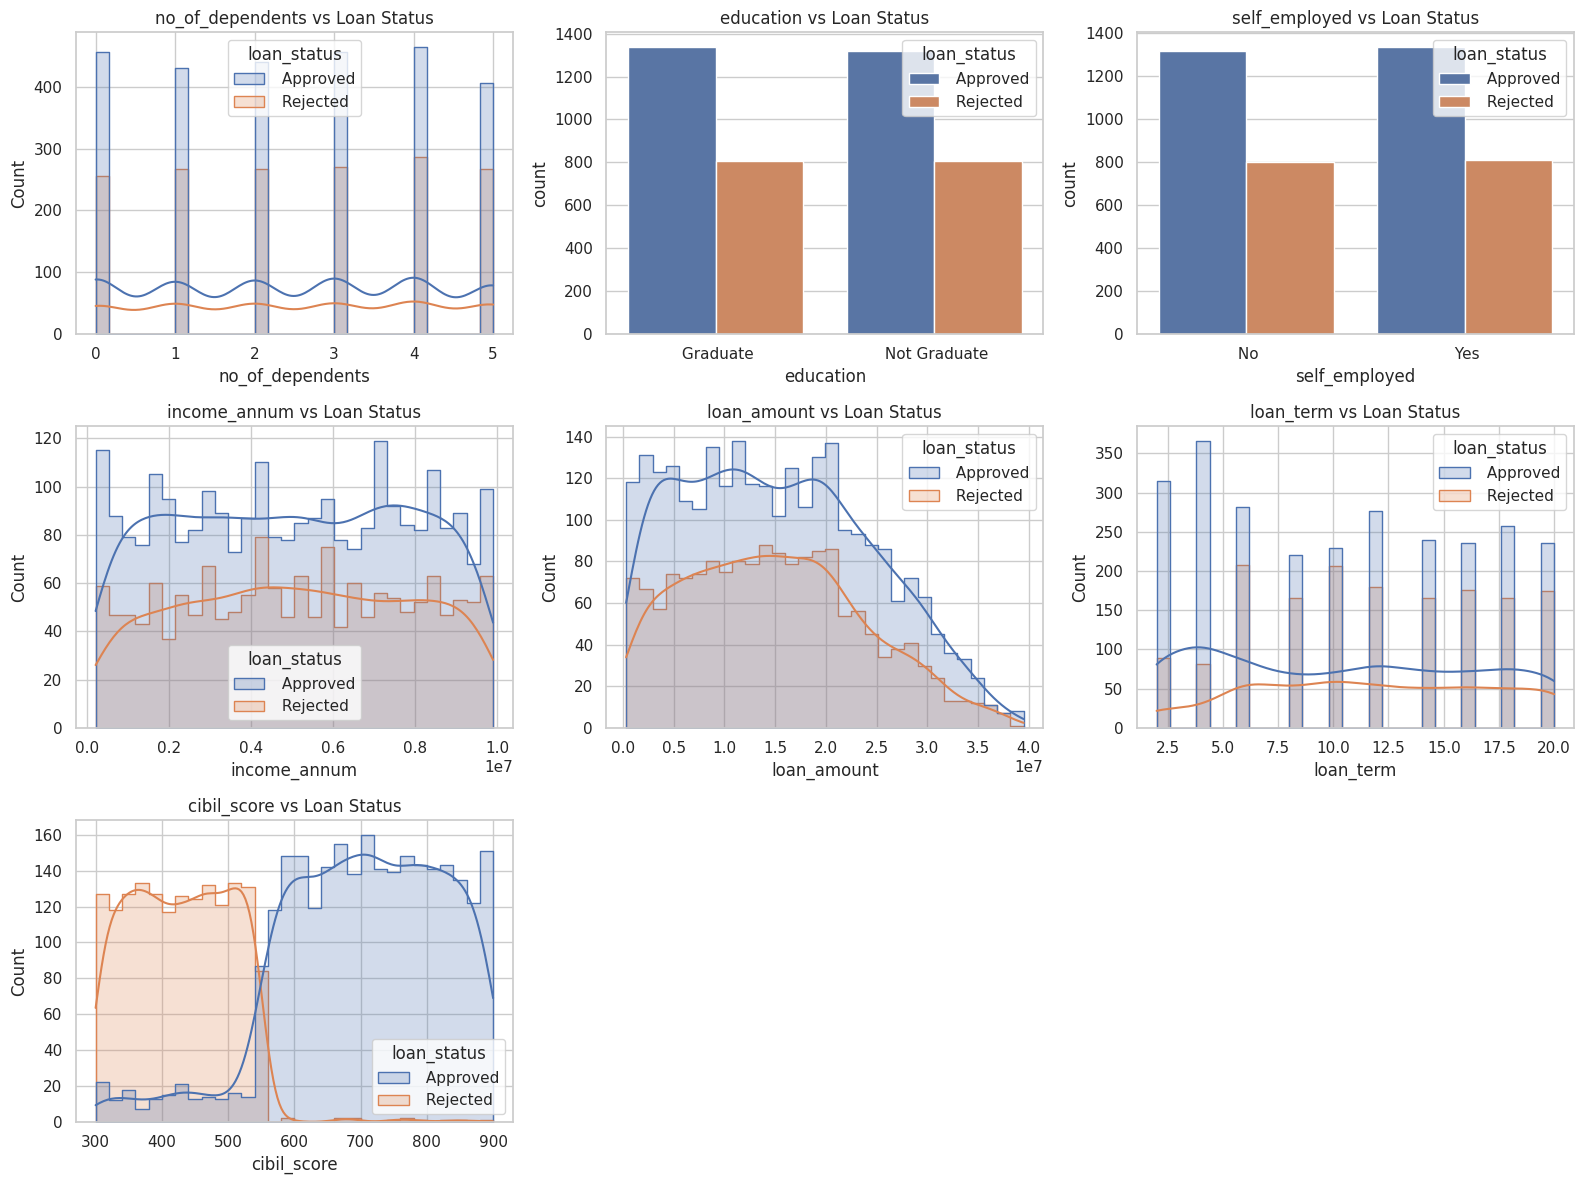

In [147]:
# Step 4: Visualizations (EDA)
sns.set(style="whitegrid")
plt.figure(figsize=(16, 12))
features = [
    'no_of_dependents', 'education', 'self_employed', 'income_annum',
    'loan_amount', 'loan_term', 'cibil_score'
]

# Strip leading/trailing spaces from column names in the dataframe
data.columns = data.columns.str.strip()

for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    if data[feature].dtype == 'object':
        sns.countplot(data=data, x=feature, hue='loan_status')
    else:
        sns.histplot(data=data, x=feature, hue='loan_status', bins=30, kde=True, element='step')
    plt.title(f'{feature} vs Loan Status')
    plt.tight_layout()
plt.show()

<Axes: xlabel='education', ylabel='count'>

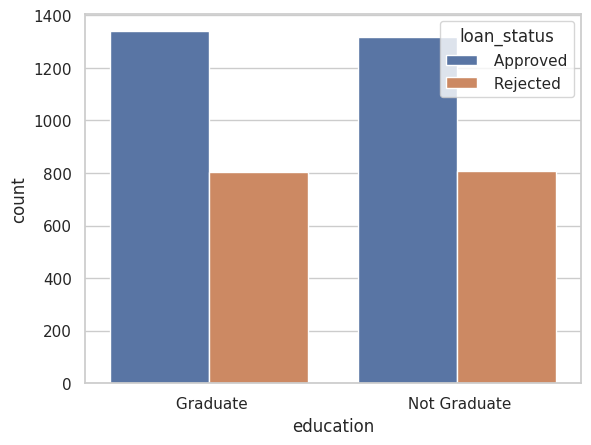

In [148]:
# Strip leading/trailing spaces from column names in the dataframe
data.columns = data.columns.str.strip()

sns.countplot(x ="education",hue="loan_status",data=data)

In [149]:
data.groupby('self_employed')['loan_status'].value_counts().unstack()

loan_status,Approved,Rejected
self_employed,,
No,1318,801
Yes,1338,812


<Axes: xlabel='self_employed', ylabel='count'>

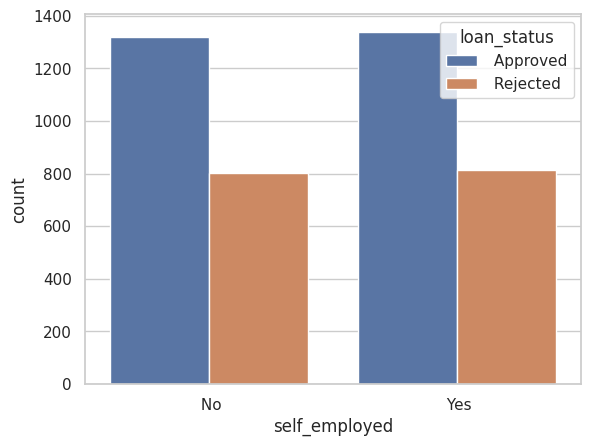

In [150]:
sns.countplot(x ="self_employed",hue="loan_status",data=data)

<Axes: >

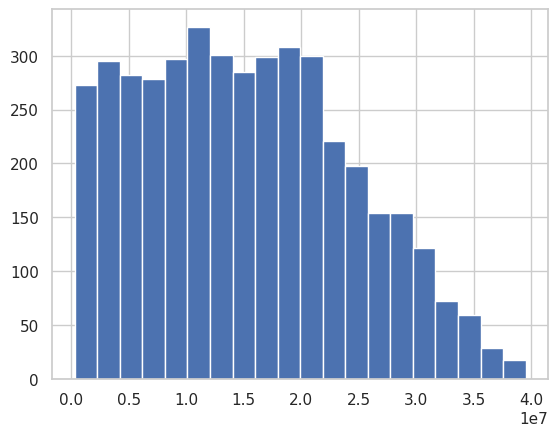

In [151]:
data['loan_amount'].hist(bins=20)

<Axes: >

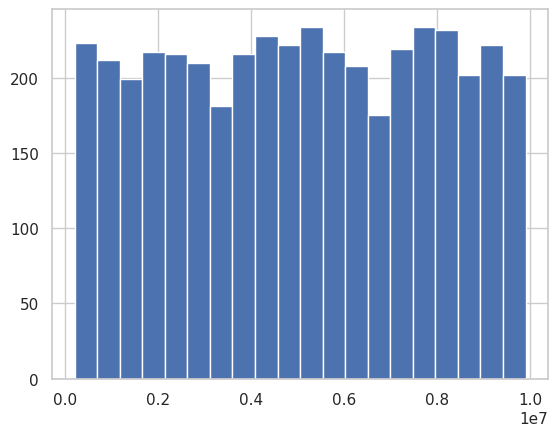

In [152]:
data['income_annum'].hist(bins=20)

#Outliers

In [153]:
# def detect_outliers(data):
#     """
#     Identifies outliers in numeric variables using the IQR method.

#     Returns:
#     - A dictionary with column names as keys and outlier values as lists.
#     """
#     outliers = {}  # Dictionary to store outliers

#     # Identify numeric columns
#     numeric_cols = data.select_dtypes(include=['number']).columns

#     for col in numeric_cols:
#         Q1 = data[col].quantile(0.25)  # First quartile
#         Q3 = data[col].quantile(0.75)  # Third quartile
#         IQR = Q3 - Q1  # Interquartile range

#         lower_bound = Q1 - 1.5 * IQR  # Lower bound
#         upper_bound = Q3 + 1.5 * IQR  # Upper bound

#         # Find outliers
#         outlier_values = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col].tolist()

#         if outlier_values:
#             outliers[col] = outlier_values  # Store outliers

#     return outliers

# # Example usage
# outlier_dict = detect_outliers(data)

# # Display outliers
# for col, values in outlier_dict.items():
#     print(f"Outliers in '{col}': {values}")

##Plot distribution to show outliers

In [154]:
# def plot_numerical_distributions(data):
#     # Strip leading/trailing spaces from column names
#     data.columns = data.columns.str.strip()
#     num_vars = data.select_dtypes(include=[np.number]).columns

#     for col in num_vars:
#         # Use .copy() to avoid SettingWithCopyWarning
#         col_data = data[col].dropna().copy()
#         col_skew = skew(col_data)

#         if col_skew > 0.5:
#             skewness_type = 'Right-skewed'
#         elif col_skew < -0.5:
#             skewness_type = 'Left-skewed'
#         else:
#             skewness_type = 'Approximately Normal'

#         # Calculate outliers using IQR
#         Q1 = col_data.quantile(0.25)
#         Q3 = col_data.quantile(0.75)
#         IQR = Q3 - Q1
#         outliers = col_data[(col_data < Q1 - 1.5 * IQR) | (col_data > Q3 + 1.5 * IQR)]

#         plt.figure(figsize=(12, 5))

#         # Histogram + KDE
#         plt.subplot(1, 2, 1)
#         sns.histplot(col_data, kde=True, bins=20, color='skyblue')
#         plt.axvline(col_data.mean(), color='red', linestyle='--', label='Mean')
#         plt.title(f"Histogram of {col}\nSkewness: {col_skew:.2f} ({skewness_type})")
#         plt.legend()

#         # Boxplot
#         plt.subplot(1, 2, 2)
#         sns.boxplot(x=col_data, color='lightgreen')
#         for outlier in outliers:
#             plt.plot(outlier, 0, 'ro')  # Mark outliers in red
#         plt.title(f"Boxplot of {col}\nOutliers: {len(outliers)}")

#         plt.tight_layout()
#         plt.show()

In [155]:
# # Plot distributions of numerical variables
# plot_numerical_distributions(data)

#treat outliers

In [156]:
# def treat_outliers_comprehensively(data, skew_thresh=1):
#     df_treated = data.copy()
#     report = []
#     numeric_cols = data.select_dtypes(include=np.number).columns

#     for col in numeric_cols:
#         col_data = data[col].dropna()
#         n = len(col_data)

#         if n < 5:
#             report.append({
#                 "Variable": col,
#                 "Skewness": "NA",
#                 "Outlier %": "NA",
#                 "Method": "Too few values"
#             })
#             continue

#         original_data = data[col]
#         transformed_data = original_data.copy()
#         col_skew = skew(col_data)
#         Q1 = col_data.quantile(0.25)
#         Q3 = col_data.quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         outliers = ((col_data < lower_bound) | (col_data > upper_bound)).sum()
#         outlier_ratio = outliers / n * 100

#         methods_used = []

#         # Step 1: Log transform if skewed and non-negative
#         if abs(col_skew) > skew_thresh and (col_data >= 0).all():
#             transformed_data = np.log1p(transformed_data)
#             methods_used.append("Log transform")
#             col_skew = skew(transformed_data.dropna())

#         # Step 2: Winsorize if still many outliers
#         Q1 = transformed_data.quantile(0.25)
#         Q3 = transformed_data.quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         outliers = ((transformed_data < lower_bound) | (transformed_data > upper_bound)).sum()
#         outlier_ratio = outliers / n * 100

#         if outlier_ratio > 10:
#             transformed_data = winsorize(transformed_data, limits=[0.05, 0.05])
#             methods_used.append("Winsorized (5–95%)")
#         elif outlier_ratio > 0:
#             transformed_data = transformed_data.clip(lower=lower_bound, upper=upper_bound)
#             methods_used.append("IQR Clipping")

#         df_treated[col] = transformed_data

#         report.append({
#             "Variable": col,
#             "Skewness": round(skew(data[col].dropna()), 2),
#             "Outlier %": round(outlier_ratio, 2),
#             "Method": " + ".join(methods_used) if methods_used else "No treatment needed"
#         })

#     report_df = pd.DataFrame(report)
#     return df_treated, report_df


# def visualize_outlier_treatment(original_df, treated_df):
#     numeric_cols = original_df.select_dtypes(include=np.number).columns

#     for col in numeric_cols:
#         plt.figure(figsize=(12, 5))

#         plt.subplot(1, 2, 1)
#         sns.boxplot(x=original_df[col], color='skyblue')
#         plt.title(f"Original: {col}")

#         plt.subplot(1, 2, 2)
#         sns.boxplot(x=treated_df[col], color='lightgreen')
#         plt.title(f"Treated: {col}")

#         plt.tight_layout()
#         plt.show()


In [157]:
# treated_df, treatment_report = treat_outliers_comprehensively(data)
# display(treatment_report)
# visualize_outlier_treatment(data, treated_df)


In [158]:
# treated_df.describe()

In [159]:
# data_transformed=treated_df

#Correlation Analysis

In [160]:
# Select only numerical features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()


# Compute correlation matrix for numerical features
corr_matrix = data[numerical_features].corr()


# Display top correlated numerical features
print("Top Correlated Numerical Features:\n")
print(corr_matrix.unstack().sort_values(ascending=False).head(50))  # Show top correlations

# Set correlation threshold
threshold = 0.75
high_corr_features = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            high_corr_features.add(colname)

print("Highly Correlated Features to Drop:", high_corr_features)

Top Correlated Numerical Features:

no_of_dependents          no_of_dependents            1.000000
income_annum              income_annum                1.000000
commercial_assets_value   commercial_assets_value     1.000000
bank_asset_value          bank_asset_value            1.000000
luxury_assets_value       luxury_assets_value         1.000000
residential_assets_value  residential_assets_value    1.000000
cibil_score               cibil_score                 1.000000
loan_term                 loan_term                   1.000000
loan_amount               loan_amount                 1.000000
luxury_assets_value       income_annum                0.929145
income_annum              luxury_assets_value         0.929145
                          loan_amount                 0.927470
loan_amount               income_annum                0.927470
                          luxury_assets_value         0.860914
luxury_assets_value       loan_amount                 0.860914
bank_asset_value   

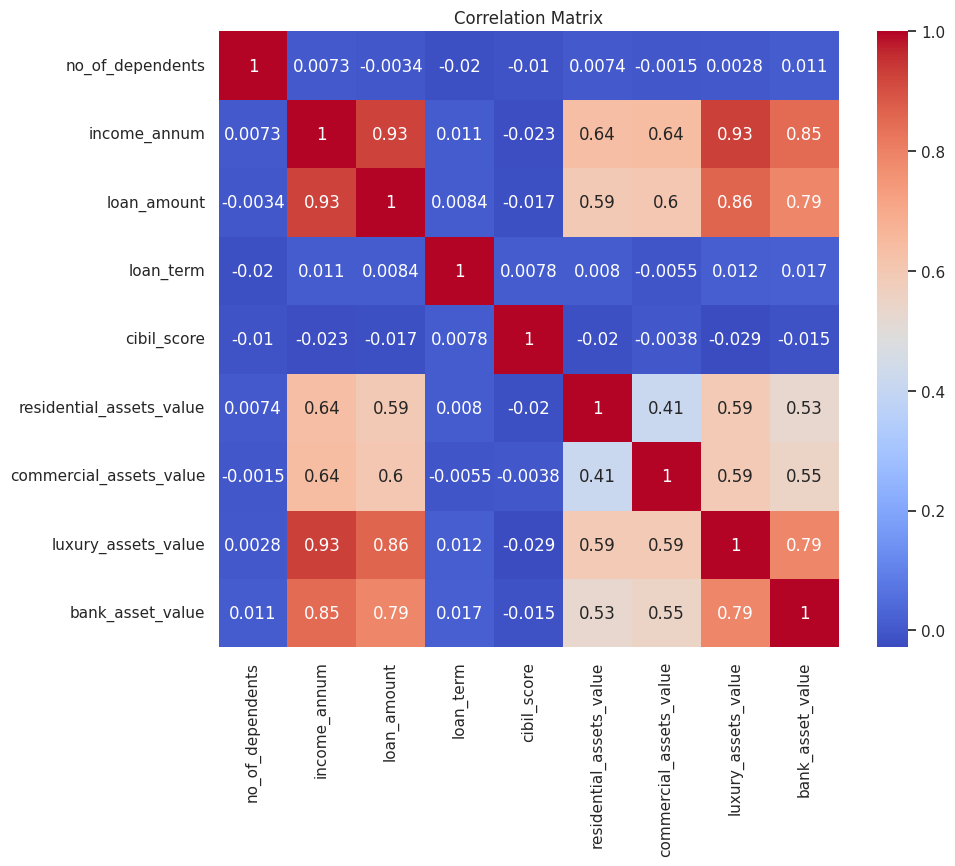

In [161]:
# Compute and visualize correlation matrix
corr_matrix = data.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [162]:


def detect_multicollinearity(data, vif_threshold=5):
    # Select numeric features only
    X = data.select_dtypes(include=np.number).dropna()

    # Add constant term for intercept (needed for VIF calculation)
    X_const = add_constant(X)

    # Compute VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_const.columns
    vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

    # Drop the intercept row
    vif_data = vif_data[vif_data["Feature"] != "const"]

    # Filter features with VIF above threshold
    high_vif = vif_data[vif_data["VIF"] > vif_threshold]

    return vif_data.sort_values(by="VIF", ascending=False), high_vif

In [163]:
vif_report, high_vif_features = detect_multicollinearity(data)

print("Full VIF Report:")
print(vif_report)

print("\nFeatures with High Multicollinearity:")
print(high_vif_features)

Full VIF Report:
                    Feature        VIF
2              income_annum  17.651087
8       luxury_assets_value   7.322253
3               loan_amount   7.168648
9          bank_asset_value   3.634872
7   commercial_assets_value   1.698313
6  residential_assets_value   1.685134
1          no_of_dependents   1.001574
5               cibil_score   1.001498
4                 loan_term   1.001160

Features with High Multicollinearity:
               Feature        VIF
2         income_annum  17.651087
3          loan_amount   7.168648
8  luxury_assets_value   7.322253


/tmp/ipython-input-164-2129749970.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data, x='debt_to_income_ratio', y='loan_status', palette=custom_palette)


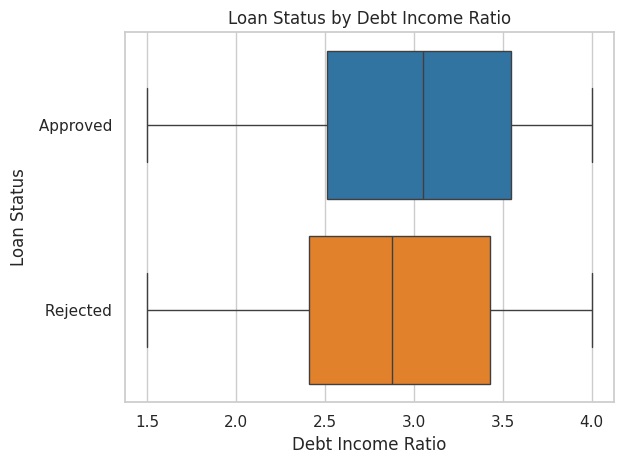

In [164]:
data['debt_to_income_ratio'] = data['loan_amount'] / data['income_annum']
# Define a custom color palette
custom_palette = ["#1f77b4", "#ff7f0e"] # Example colors

sns.boxplot(data, x='debt_to_income_ratio', y='loan_status', palette=custom_palette)
plt.title('Loan Status by Debt Income Ratio')
plt.xlabel('Debt Income Ratio')
plt.ylabel('Loan Status')

plt.tight_layout()
plt.show()

In [165]:
#data.drop(columns=['loan_amount'], inplace=True)

In [166]:
def detect_multicollinearity(data, vif_threshold=5):
    # Select numeric features only
    X = data.select_dtypes(include=np.number).dropna()

    # Add constant term for intercept (needed for VIF calculation)
    X_const = add_constant(X)

    # Compute VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_const.columns
    vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

    # Drop the intercept row
    vif_data = vif_data[vif_data["Feature"] != "const"]

    # Filter features with VIF above threshold
    high_vif = vif_data[vif_data["VIF"] > vif_threshold]

    return vif_data.sort_values(by="VIF", ascending=False), high_vif

In [167]:
vif_report, high_vif_features = detect_multicollinearity(data)

print("Full VIF Report:")
print(vif_report)

print("\nFeatures with High Multicollinearity:")
print(high_vif_features)

Full VIF Report:
                     Feature        VIF
2               income_annum  35.532148
3                loan_amount  28.011919
8        luxury_assets_value   7.322815
10      debt_to_income_ratio   3.914894
9           bank_asset_value   3.635489
7    commercial_assets_value   1.698537
6   residential_assets_value   1.685135
1           no_of_dependents   1.001723
5                cibil_score   1.001664
4                  loan_term   1.001171

Features with High Multicollinearity:
               Feature        VIF
2         income_annum  35.532148
3          loan_amount  28.011919
8  luxury_assets_value   7.322815


In [168]:
# Apply Label Encoding to binary categorical variables
categorical_cols = data.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    if data[col].nunique() == 2:  # Binary category
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le  # Store encoder for later use

# Apply One-Hot Encoding for multi-category variables
df = pd.get_dummies(data, columns=[col for col in categorical_cols if data[col].nunique() > 2], drop_first=True)

print("Categorical variables converted to numeric.")

# Get updated categorical columns after one-hot encoding
categorical_cols_after_dummies = df.select_dtypes(include=['object']).columns

# Apply One-Hot Encoding for the remaining multi-category variables if any
# This step is only necessary if there are still object type columns with more than 2 unique values.
if len(categorical_cols_after_dummies) > 0:
    df = pd.get_dummies(df, columns=categorical_cols_after_dummies, drop_first=True)
    print("Remaining categorical variables converted to numeric.") #added a message
else:
    print("No remaining categorical columns to convert.")

print("Categorical variables converted to numeric.")

Categorical variables converted to numeric.
No remaining categorical columns to convert.
Categorical variables converted to numeric.


In [169]:
# Define features (X) and target variable (y)
X = df.drop(columns=["loan_status"])
y = df["loan_status"]

# Check class distribution before balancing
print("Before Balancing:", Counter(y))

# Apply SMOTE if imbalance exists
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check class distribution after balancing
print("After Balancing:", Counter(y_resampled))

Before Balancing: Counter({0: 2656, 1: 1613})
After Balancing: Counter({0: 2656, 1: 2656})


In [170]:
# Split into 80% training & 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (4249, 12)
Testing set size: (1063, 12)


In [171]:
from sklearn.preprocessing import StandardScaler

# Select only numerical features for scaling
numerical_cols = X_train.select_dtypes(include=['number']).columns

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data & transform both train and test sets
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("Numerical features standardized.")

Numerical features standardized.


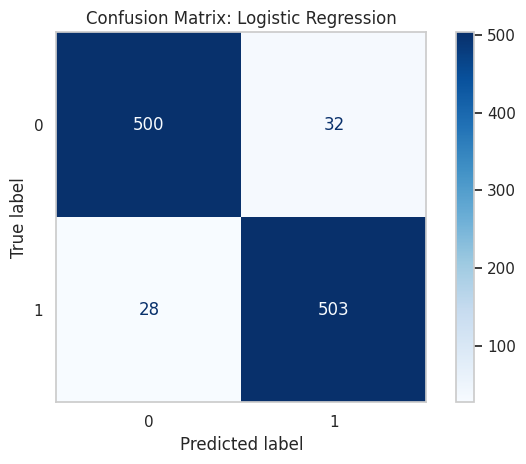

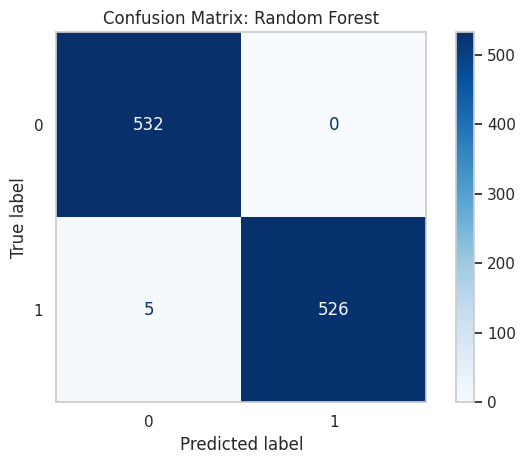

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:08:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


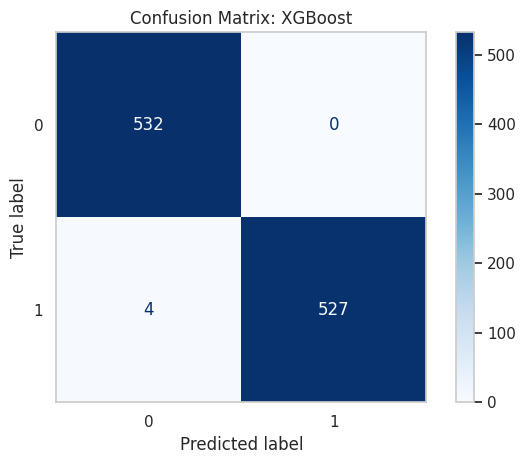

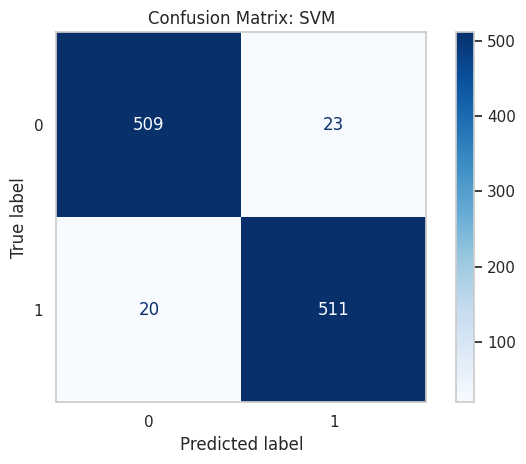

Model Performance Summary:

                 Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
0              XGBoost    0.9962     1.0000  0.9925    0.9962   0.9996
1        Random Forest    0.9953     1.0000  0.9906    0.9953   0.9997
2                  SVM    0.9595     0.9569  0.9623    0.9596   0.9926
3  Logistic Regression    0.9436     0.9402  0.9473    0.9437   0.9790


In [172]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(class_weight="balanced", n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", class_weight="balanced", random_state=42)  # SVM with RBF Kernel
}
# Train and evaluate models + confusion matrices
results = []
trained_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else float('nan')

    results.append([name, accuracy, precision, recall, f1, auc])
    trained_models[name] = model

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_ if hasattr(model, "classes_") else [0, 1])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Create and display performance table
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC"])
results_df = results_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

print("Model Performance Summary:\n")
print(results_df.round(4))

In [173]:
# Define models
models = [
    ('Logistic Regression', LogisticRegression(C=10, penalty='l2', random_state=42)),
    ('Random Forest', SVC(C=1, kernel='rbf', probability=True, random_state=42)),  # Enable proba for soft voting
    ('XGBoost', XGBClassifier(learning_rate=0.1, max_depth=5, random_state=42))
]

# Hard Voting (majority vote) - This was already done in input-36
voting_clf = VotingClassifier(estimators=models, voting='hard')
voting_clf.fit(X_train, y_train)

# Soft Voting - Define and fit voting_clf_soft
voting_clf_soft = VotingClassifier(estimators=models, voting='soft')  # Define for soft voting
voting_clf_soft.fit(X_train, y_train)  # Fit the soft voting classifier


# Hard Voting
y_pred_hard = voting_clf.predict(X_test)
print("Hard Voting Results:")
print(classification_report(y_test, y_pred_hard))
print(f"Accuracy: {accuracy_score(y_test, y_pred_hard):.4f}")

# Soft Voting
y_pred_soft = voting_clf_soft.predict(X_test)  # Now voting_clf_soft is defined
print("\nSoft Voting Results:")
print(classification_report(y_test, y_pred_soft))
print(f"Accuracy: {accuracy_score(y_test, y_pred_soft):.4f}")


Hard Voting Results:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       532
           1       0.97      0.97      0.97       531

    accuracy                           0.97      1063
   macro avg       0.97      0.97      0.97      1063
weighted avg       0.97      0.97      0.97      1063

Accuracy: 0.9699

Soft Voting Results:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       532
           1       0.99      0.98      0.98       531

    accuracy                           0.98      1063
   macro avg       0.98      0.98      0.98      1063
weighted avg       0.98      0.98      0.98      1063

Accuracy: 0.9849


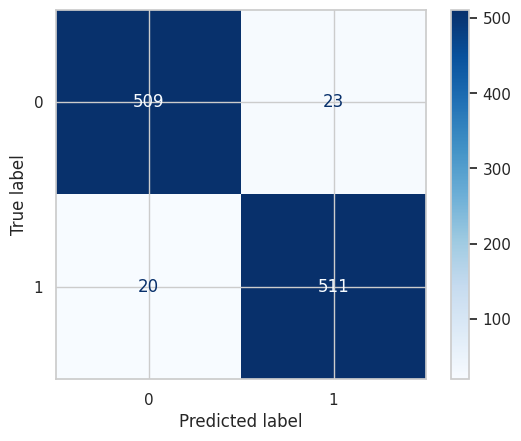

In [174]:
# Predict
y_pred_hard = model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_hard)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

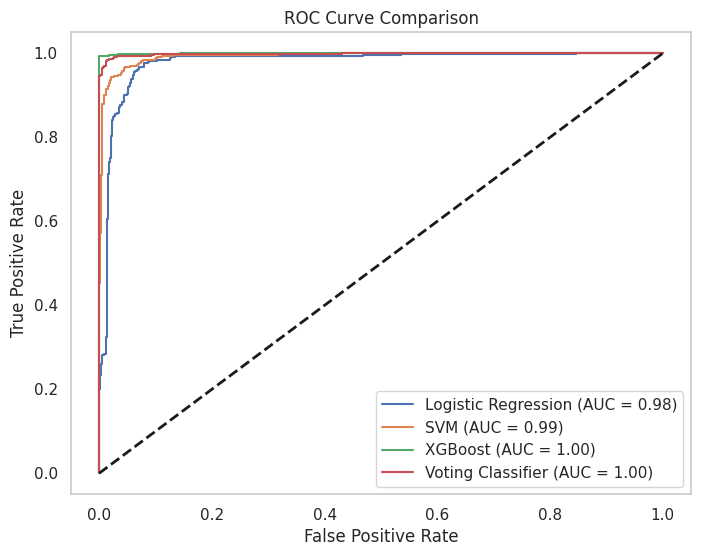

In [175]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier


# Assuming 'trained_models' contains your fitted models
models = {
    "Logistic Regression": trained_models["Logistic Regression"],
    "SVM": trained_models["SVM"],
    "XGBoost": trained_models["XGBoost"],
    "Voting Classifier": voting_clf_soft # Use voting_clf_soft for soft voting
}

plt.figure(figsize=(8, 6))

for name, model in models.items():
    # model.fit(X_train, y_train)  # No need to refit if already trained
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc_score_value = auc(fpr, tpr) # Renamed variable to avoid conflict
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score_value:.2f})")

# Plot baseline
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

In [176]:
# --- Define base models ---
models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(class_weight="balanced", n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", class_weight="balanced", random_state=42)
}

# --- Add Voting Classifier ---
voting_clf = VotingClassifier(
    estimators=[('lr', models["Logistic Regression"]),
                ('rf', models["Random Forest"]),
                ('xgb', models["XGBoost"])],
    voting='soft'
)

# Add it to the models dictionary for unified handling
models["Voting Classifier"] = voting_clf

# --- Train and evaluate ---
results = []
trained_models = {}
conf_matrices = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else float('nan')

    results.append([name, accuracy, precision, recall, f1, auc])
    trained_models[name] = model
    conf_matrices[name] = confusion_matrix(y_test, y_pred)




/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:09:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:09:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


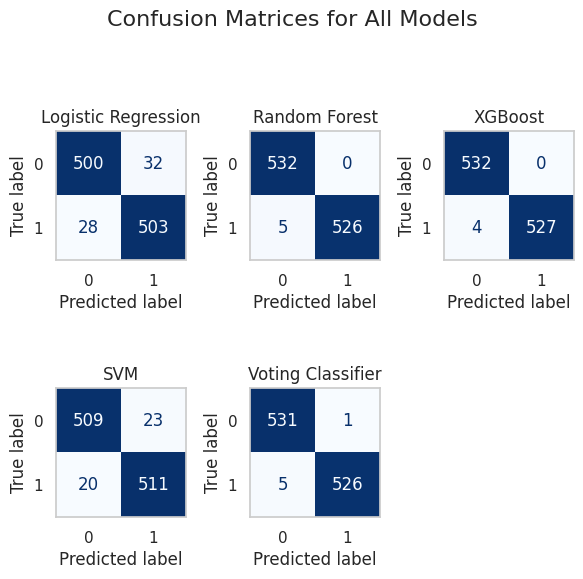

<Figure size 640x480 with 0 Axes>

In [177]:
# --- Plot all confusion matrices in one figure ---
fig, axes = plt.subplots(2, 3, figsize=(6, 6))  # Adjust depending on model count
axes = axes.flatten()

for idx, (name, cm) in enumerate(conf_matrices.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[idx], cmap='Blues', colorbar=False)
    axes[idx].set_title(name)
    axes[idx].grid(False)

# Hide any extra subplots (if < 6 models)
for j in range(len(conf_matrices), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Confusion Matrices for All Models", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- Performance Summary ---
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC"])
results_df = results_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)




plt.savefig("confusion_matrices.png", dpi=300, bbox_inches='tight')  # Saves as PNG
plt.show()

In [178]:
# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 2: Random Forest
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf_search = RandomizedSearchCV(rf, rf_params, cv=cv, scoring='f1', n_iter=20, n_jobs=-1, random_state=42)
rf_search.fit(X_train, y_train)

# Step 3: XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
xgb_search = RandomizedSearchCV(xgb, xgb_params, cv=cv, scoring='f1', n_iter=20, n_jobs=-1, random_state=42)
xgb_search.fit(X_train, y_train)

# Step 4: Logistic Regression
#lr = LogisticRegression(solver='liblinear', random_state=42)
#lr_params = {
#    'C': [0.01, 0.1, 1, 10, 100],
 #   'penalty': ['l1', 'l2']
#}
#lr_search = GridSearchCV(lr, lr_params, cv=cv, scoring='f1', n_jobs=-1)
#lr_search.fit(X_train, y_train)

# Step 5: SVM
#svm = SVC(probability=True, random_state=42)
#svm_params = {
#    'C': [0.1, 1, 10],
#    'kernel': ['linear', 'rbf'],
#    'gamma': ['scale', 'auto']
#}
#svm_search = GridSearchCV(svm, svm_params, cv=cv, scoring='f1', n_jobs=-1)
#svm_search.fit(X_train, y_train)

# Step 6: Final Evaluation on Test Set
best_models = {
    "Random Forest": rf_search.best_estimator_,
    "XGBoost": xgb_search.best_estimator_,
#    "Logistic Regression": lr_search.best_estimator_,
#    "SVM": svm_search.best_estimator_
}

for name, model in best_models.items():
    print(f"\n{name} - Best Parameters:")
    if hasattr(model, 'get_params'):
        print(model.get_params())

    print(f"\n{name} - Test Evaluation:")
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:11:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Random Forest - Best Parameters:
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Random Forest - Test Evaluation:
[[532   0]
 [  5 526]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       532
           1       1.00      0.99      1.00       531

    accuracy                           1.00      1063
   macro avg       1.00      1.00      1.00      1063
weighted avg       1.00      1.00      1.00      1063


XGBoost - Best Parameters:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None,

Random Forest Accuracy: 0.9953
XGBoost Accuracy: 0.9972


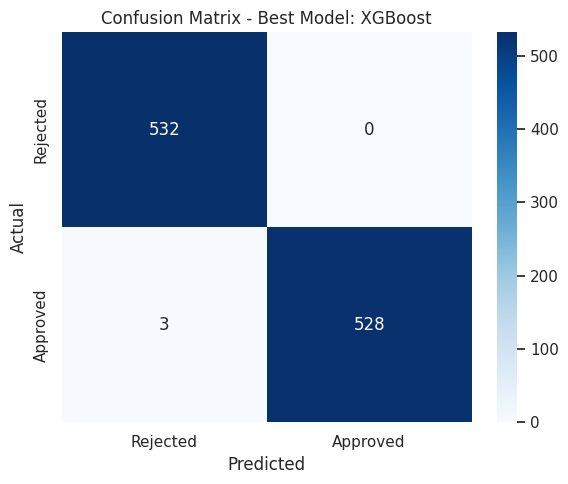

In [179]:
# Step 1: Identify best model by accuracy
best_model_name = None
best_model = None
best_accuracy = 0

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    if acc > best_accuracy:
        best_accuracy = acc
        best_model_name = name
        best_model = model

# Step 2: Predict and get confusion matrix
y_best_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_best_pred)
labels = ['Rejected', 'Approved']

# Step 3: Plot using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title(f'Confusion Matrix - Best Model: {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


In [192]:
import joblib

# Save the best model to a file
joblib.dump(best_model, 'loan_approval_model.pkl')

# Optionally save the scaler if you used one
# joblib.dump(scaler, 'scaler.pkl')


['loan_approval_model.pkl']

#Feature Importance


/tmp/ipython-input-180-2462344738.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="mako")


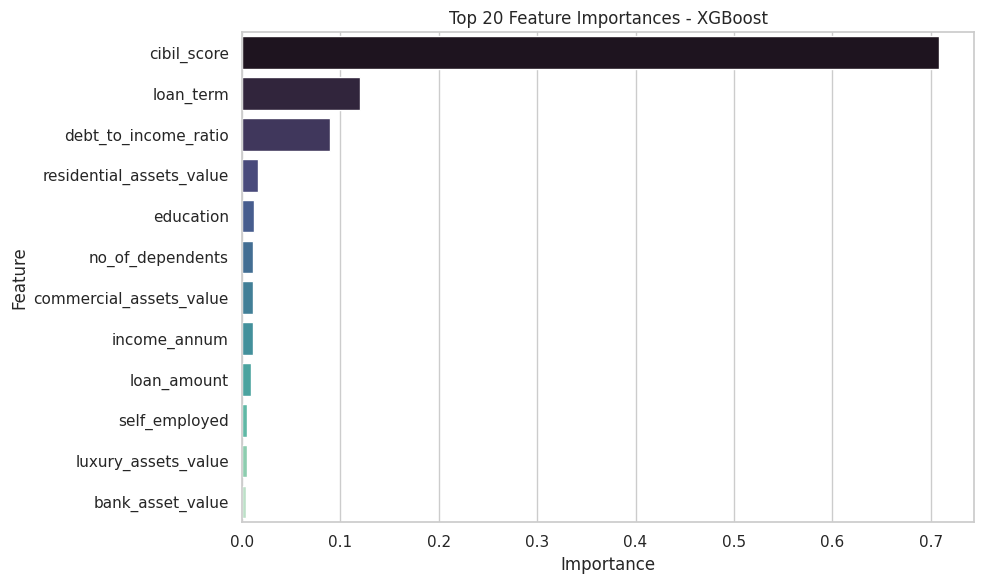

/tmp/ipython-input-180-2462344738.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="mako")


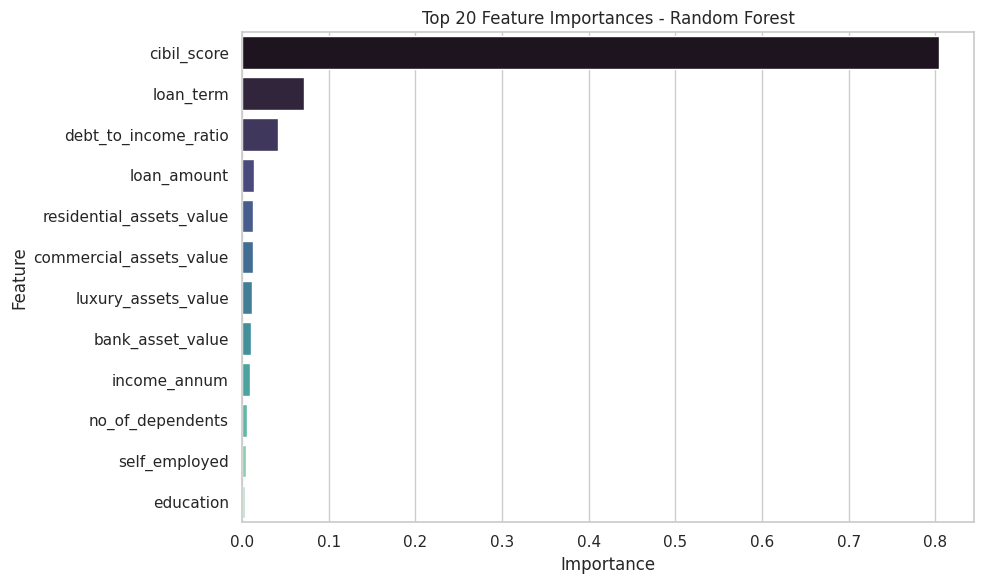

/tmp/ipython-input-180-2462344738.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="mako")


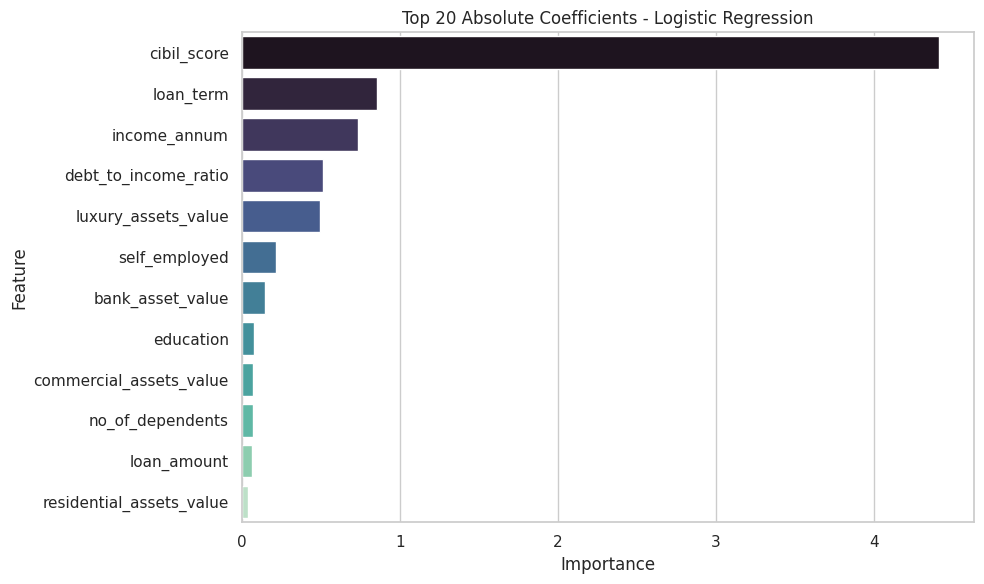

In [180]:
# --- Step 3: Extract Feature Importances ---
lr_model = trained_models["Logistic Regression"]
rf_model = trained_models["Random Forest"]
xgb_model = trained_models["XGBoost"]

lr_importance = pd.DataFrame({
    "Feature": X_resampled.columns,
    "Importance": np.abs(lr_model.coef_[0])
}).sort_values(by="Importance", ascending=False)

rf_importance = pd.DataFrame({
    "Feature": X_resampled.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

xgb_importance = pd.DataFrame({
    "Feature": X_resampled.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# --- Step 4: Plotting Function ---
def plot_importance(importance_df, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="mako")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# --- Step 5: Generate Plots ---
plot_importance(xgb_importance, "Top 20 Feature Importances - XGBoost")
plot_importance(rf_importance, "Top 20 Feature Importances - Random Forest")
plot_importance(lr_importance, "Top 20 Absolute Coefficients - Logistic Regression")

🔝 Top 4 Averaged Feature Importances:
                     Feature  Average_Importance
0                cibil_score            0.695917
1                  loan_term            0.100790
3       debt_to_income_ratio            0.065558
2               income_annum            0.038667
4        luxury_assets_value            0.026686
5              self_employed            0.012601
11  residential_assets_value            0.011055
6           bank_asset_value            0.010791
8    commercial_assets_value            0.010718
10               loan_amount            0.010215
7                  education            0.008506
9           no_of_dependents            0.008496


/tmp/ipython-input-181-3162228052.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


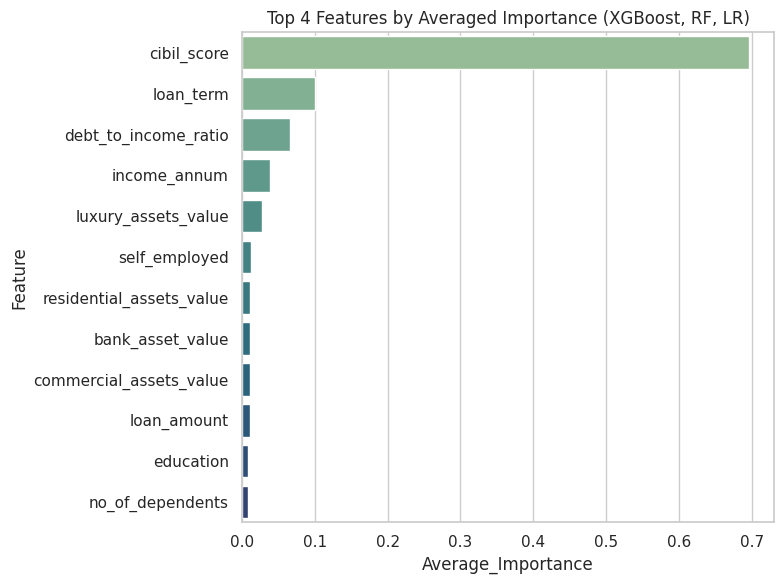

In [181]:
# Normalize each importance vector to sum to 1
lr_norm = lr_importance.copy()
rf_norm = rf_importance.copy()
xgb_norm = xgb_importance.copy()

lr_norm["Importance"] = lr_norm["Importance"] / lr_norm["Importance"].sum()
rf_norm["Importance"] = rf_norm["Importance"] / rf_norm["Importance"].sum()
xgb_norm["Importance"] = xgb_norm["Importance"] / xgb_norm["Importance"].sum()

# Merge on 'Feature'
merged = lr_norm.merge(rf_norm, on="Feature", suffixes=("_LR", "_RF"))
merged = merged.merge(xgb_norm, on="Feature")
merged = merged.rename(columns={"Importance": "Importance_XGB"})

# Average the normalized importances
merged["Average_Importance"] = merged[["Importance_LR", "Importance_RF", "Importance_XGB"]].mean(axis=1)

# Sort by average importance
merged_sorted = merged.sort_values(by="Average_Importance", ascending=False)

# Show top 20
print("🔝 Top 4 Averaged Feature Importances:")
print(merged_sorted[["Feature", "Average_Importance"]].head(20))

# Plot top 20
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.barplot(
    x="Average_Importance",
    y="Feature",
    data=merged_sorted[["Feature", "Average_Importance"]].head(16),
    palette="crest"
)
plt.title("Top 4 Features by Averaged Importance (XGBoost, RF, LR)")
plt.tight_layout()
plt.show()


#Retrain models with selectex features

In [182]:
# --- Step 1: Top 4 features from previous output ---
top_6_features = [
    'cibil_score', 'loan_term', 'income_annum','debt_to_income_ratio','luxury_assets_value','bank_asset_value'
]

# --- Step 2: Subset data ---
X_top6 = X[top_6_features]
y = df["loan_status"].astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_top6, y, test_size=0.2, stratify=y, random_state=42)

# --- Step 3: Define base models for ensemble ---
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# --- Step 4: Voting Classifier (Soft Voting) ---
voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgb)],
    voting='soft'
)

# --- Step 5: Train model ---
voting_clf.fit(X_train, y_train)

# --- Step 6: Evaluate model ---
y_pred = voting_clf.predict(X_test)
y_proba = voting_clf.predict_proba(X_test)[:, 1]

# --- Step 7: Print performance ---
print("✅ Retrained Model on Top 4 Features:")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score : {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC  : {roc_auc_score(y_test, y_proba):.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:11:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Retrained Model on Top 4 Features:
Accuracy : 0.9941
Precision: 0.9969
Recall   : 0.9876
F1-Score : 0.9922
AUC-ROC  : 0.9937


In [183]:
X_resampled, y_resampled = smote.fit_resample(X, y)

In [184]:
# import pandas as pd
# import numpy as np
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# from xgboost import XGBClassifier
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score,
#     f1_score, roc_auc_score, classification_report
#)

# --- Step 1: Top 20 important features ---
top_6_features = [
    'cibil_score', 'loan_term', 'income_annum','debt_to_income_ratio','luxury_assets_value','bank_asset_value'
]

# --- Step 2: Subset full and top-20 feature datasets ---
X_full_resampled = pd.DataFrame(X_resampled, columns=X.columns)
X_top20_resampled = X_full_resampled[top_6_features]
y_resampled = y_resampled # Use the resampled y

# Split both versions identically
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_full_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

X_train_top, X_test_top, _, _ = train_test_split(
    X_top20_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
) # Added missing parenthesis here

# --- Step 3: Initialize Models ---
models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight="balanced", n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", class_weight="balanced", random_state=42)
}

# Voting classifier with top 3 models
voting_clf = VotingClassifier(
    estimators=[('lr', models['Logistic Regression']),
                ('rf', models['Random Forest']),
                ('xgb', models['XGBoost'])],
    voting='soft'
)

# --- Step 4: Fit models on top-20 features and store results ---
results_top20 = []

for name, model in models.items():
    model.fit(X_train_top, y_train)
    y_pred = model.predict(X_test_top)
    y_prob = model.predict_proba(X_test_top)[:, 1]
    results_top20.append([
        name,
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, y_prob)
    ])

# Voting Classifier
voting_clf.fit(X_train_top, y_train)
y_pred_vote = voting_clf.predict(X_test_top)
y_prob_vote = voting_clf.predict_proba(X_test_top)[:, 1]
results_top20.append([
    "Voting Classifier",
    accuracy_score(y_test, y_pred_vote),
    precision_score(y_test, y_pred_vote),
    recall_score(y_test, y_pred_vote),
    f1_score(y_test, y_pred_vote),
    roc_auc_score(y_test, y_prob_vote)
])

# --- Step 5: Evaluate original full-feature models for comparison ---
results_full = []

for name, model in models.items():
    model.fit(X_train_full, y_train)
    y_pred = model.predict(X_test_full)
    y_prob = model.predict_proba(X_test_full)[:, 1]
    results_full.append([
        name + " (Full)",
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, y_prob)
    ])

# --- Step 6: Combine and compare results ---
columns = ["Model", "Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC"]
results_df = pd.DataFrame(results_top20 + results_full, columns=columns)

# Sort by F1-Score
results_df_sorted = results_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

# Display final comparison
print("📊 Model Performance: Top 4 Features vs Full Model\n")
print(results_df_sorted.round(4))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:11:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:11:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:11:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 Model Performance: Top 4 Features vs Full Model

                        Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
0              XGBoost (Full)    0.9962     1.0000  0.9925    0.9962   0.9996
1        Random Forest (Full)    0.9953     1.0000  0.9906    0.9953   0.9997
2               Random Forest    0.9953     1.0000  0.9906    0.9953   0.9989
3           Voting Classifier    0.9944     0.9981  0.9906    0.9943   0.9971
4                     XGBoost    0.9944     0.9981  0.9906    0.9943   0.9995
5  Logistic Regression (Full)    0.7582     0.8072  0.6780    0.7369   0.8698
6         Logistic Regression    0.7554     0.8101  0.6667    0.7314   0.8633
7                         SVM    0.5193     0.5142  0.6798    0.5856   0.5179
8                  SVM (Full)    0.5390     0.5501  0.4237    0.4787   0.5441


/tmp/ipython-input-185-2462344738.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="mako")


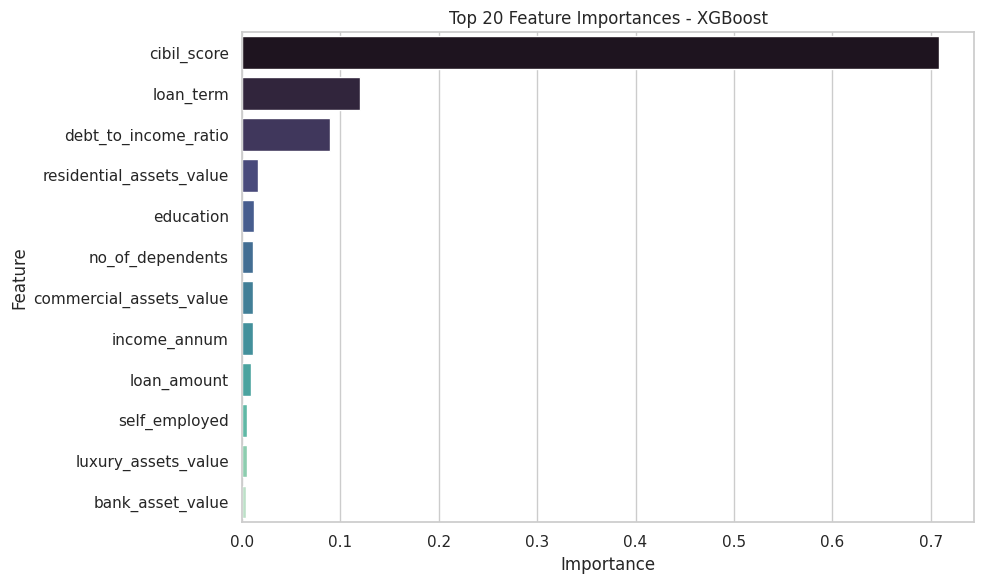

/tmp/ipython-input-185-2462344738.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="mako")


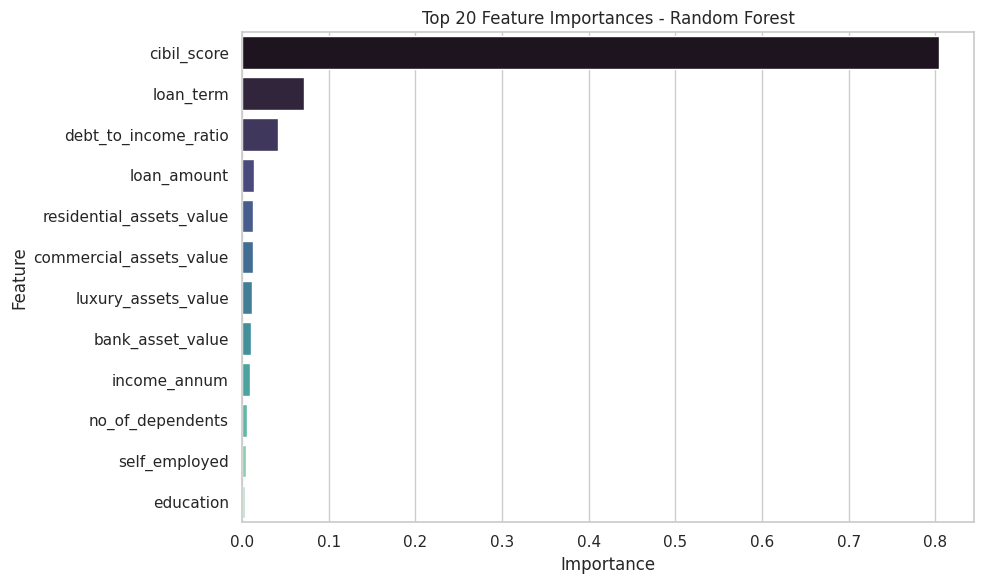

/tmp/ipython-input-185-2462344738.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="mako")


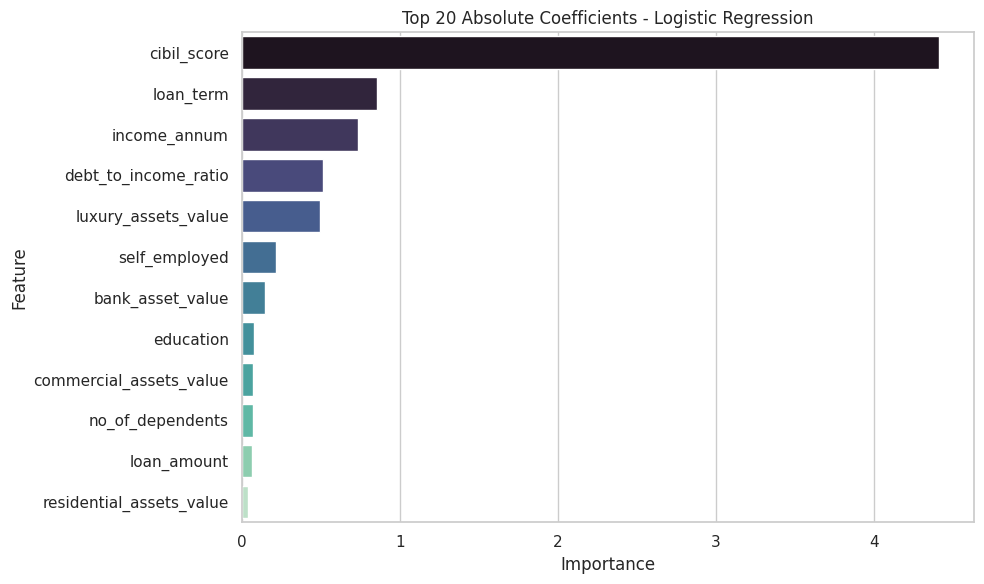

In [185]:
# --- Step 3: Extract Feature Importances ---
lr_model = trained_models["Logistic Regression"]
rf_model = trained_models["Random Forest"]
xgb_model = trained_models["XGBoost"]

lr_importance = pd.DataFrame({
    "Feature": X_resampled.columns,
    "Importance": np.abs(lr_model.coef_[0])
}).sort_values(by="Importance", ascending=False)

rf_importance = pd.DataFrame({
    "Feature": X_resampled.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

xgb_importance = pd.DataFrame({
    "Feature": X_resampled.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# --- Step 4: Plotting Function ---
def plot_importance(importance_df, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="mako")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# --- Step 5: Generate Plots ---
plot_importance(xgb_importance, "Top 20 Feature Importances - XGBoost")
plot_importance(rf_importance, "Top 20 Feature Importances - Random Forest")
plot_importance(lr_importance, "Top 20 Absolute Coefficients - Logistic Regression")



Findings: From the models, we found several key factors that influence loan eligibility: Credit Score (CIBIL): A higher CIBIL score strongly predicts loan approval. Self-Employment: Self-employed applicants have a lower likelihood of loan approval compared to salaried applicants. Income: Higher income levels also correlate positively with loan approval. Education: Applicants with higher education levels are more likely to have their loans approved. Both the logistic regression and decision tree models provided accuracy scores of around 80%, with the decision tree performing slightly better.

Limitations: Imbalanced Data: The dataset has more approved loans than rejected ones, which may affect the model's generalizability. Missing Variables: More detailed financial information (e.g., existing liabilities, savings) could improve the model's predictions.

Conclusion: The study demonstrates that factors such as credit score, income, and education play a critical role in determining loan eligibility. Self-employed applicants face more challenges in loan approval, potentially due to perceived financial instability. Financial institutions can use these insights to enhance their loan approval processes and reduce processing time by automating loan eligibility assessments.

Further Questions: How would the inclusion of additional financial data, like savings and liabilities, affect the model’s performance? Can advanced machine learning models like random forests or XGBoost improve prediction accuracy?


In [187]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   no_of_dependents          4269 non-null   int64  
 1   education                 4269 non-null   int64  
 2   self_employed             4269 non-null   int64  
 3   income_annum              4269 non-null   int64  
 4   loan_amount               4269 non-null   int64  
 5   loan_term                 4269 non-null   int64  
 6   cibil_score               4269 non-null   int64  
 7   residential_assets_value  4269 non-null   int64  
 8   commercial_assets_value   4269 non-null   int64  
 9   luxury_assets_value       4269 non-null   int64  
 10  bank_asset_value          4269 non-null   int64  
 11  loan_status               4269 non-null   int64  
 12  debt_to_income_ratio      4269 non-null   float64
dtypes: float64(1), int64(12)
memory usage: 433.7 KB


In [190]:
!pip install streamlit pandas scikit-learn xgboost joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.8 MB/s eta 0:00:00


In [194]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib

# Load the best trained model
model = joblib.load("loan_approval_model.pkl")  # Ensure you've saved your model as best_model.pkl

# Title
st.title("🏦 Loan Approval Prediction App")

st.markdown("""
This app predicts whether a **loan** will be approved or rejected based on applicant details.
""")

# User input
st.header("Enter Applicant Details:")

no_of_dependents = st.number_input("Number of Dependents", min_value=0, step=1)
education = st.selectbox("Education Level", ['Graduate', 'Not Graduate'])
self_employed = st.selectbox("Self Employed?", ['Yes', 'No'])
income_annum = st.number_input("Annual Income (ZMW)", min_value=0.0, step=1000.0)
loan_amount = st.number_input("Loan Amount Requested (ZMW)", min_value=0.0, step=1000.0)
loan_term = st.number_input("Loan Tenure (in years)", min_value=1, step=1)
cibil_score = st.slider("CIBIL Score", min_value=300, max_value=900, step=10)
res_asset = st.number_input("Residential Asset Value", min_value=0.0, step=1000.0)
comm_asset = st.number_input("Commercial Asset Value", min_value=0.0, step=1000.0)
lux_asset = st.number_input("Luxury Asset Value", min_value=0.0, step=1000.0)
bank_asset = st.number_input("Bank Asset Value", min_value=0.0, step=1000.0)

# Compute DTI
if income_annum > 0:
    dti_ratio = loan_amount / income_annum
else:
    dti_ratio = 0

st.write(f"**Debt-to-Income Ratio:** {dti_ratio:.2f}")

# Prepare input for prediction
input_data = pd.DataFrame({
    'no_of_dependents': [no_of_dependents],
    'education': [education],
    'self_employed': [self_employed],
    'income_annum': [income_annum],
    'loan_amount': [loan_amount],
    'loan_term': [loan_term],
    'cibil_score': [cibil_score],
    'residential_asset_value': [res_asset],
    'commercial_asset_value': [comm_asset],
    'luxury_asset_value': [lux_asset],
    'bank_assets_value': [bank_asset],
    'dti_ratio': [dti_ratio]
})

# Match training preprocessing (example encoding)
input_data['education'] = input_data['education'].map({'Graduate': 1, 'Not Graduate': 0})
input_data['self_employed'] = input_data['self_employed'].map({'Yes': 1, 'No': 0})

# Drop original loan_amount and income_annum if not used in training
# input_data.drop(['income_annum', 'loan_amount'], axis=1, inplace=True)

# Predict
if st.button("Predict Loan Approval"):
    prediction = model.predict(input_data)[0]
    result = "✅ Approved" if prediction == 1 else "❌ Rejected"
    st.subheader(f"Prediction Result: {result}")


2025-07-20 09:34:54.501 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-20 09:34:54.601 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-20 09:34:54.605 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-20 09:34:54.607 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-20 09:34:54.609 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-20 09:34:54.612 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-20 09:34:54.613 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-20 09:34:54.614 Thread 'MainThread': mi

In [199]:
# Create a Python file with the Streamlit app code
streamlit_code = """
import streamlit as st
import pandas as pd
import numpy as np
import joblib

# Load the best trained model
model = joblib.load("loan_approval_model.pkl")  # Ensure you've saved your model as best_model.pkl

# Title
st.title("🏦 Loan Approval Prediction App")

st.markdown(\"\"\"
This app predicts whether a **loan** will be approved or rejected based on applicant details.
\"\"\")

# User input
st.header("Enter Applicant Details:")

no_of_dependents = st.number_input("Number of Dependents", min_value=0, step=1)
education = st.selectbox("Education Level", ['Graduate', 'Not Graduate'])
self_employed = st.selectbox("Self Employed?", ['Yes', 'No'])
income_annum = st.number_input("Annual Income (ZMW)", min_value=0.0, step=1000.0)
loan_amount = st.number_input("Loan Amount Requested (ZMW)", min_value=0.0, step=1000.0)
loan_term = st.number_input("Loan Tenure (in years)", min_value=1, step=1)
cibil_score = st.slider("CIBIL Score", min_value=300, max_value=900, step=10)
res_asset = st.number_input("Residential Asset Value", min_value=0.0, step=1000.0)
comm_asset = st.number_input("Commercial Asset Value", min_value=0.0, step=1000.0)
lux_asset = st.number_input("Luxury Asset Value", min_value=0.0, step=1000.0)
bank_asset = st.number_input("Bank Asset Value", min_value=0.0, step=1000.0)

# Compute DTI
if income_annum > 0:
    dti_ratio = loan_amount / income_annum
else:
    dti_ratio = 0

st.write(f"**Debt-to-Income Ratio:** {dti_ratio:.2f}")

# Prepare input for prediction
input_data = pd.DataFrame({
    'no_of_dependents': [no_of_dependents],
    'education': [education],
    'self_employed': [self_employed],
    'income_annum': [income_annum],
    'loan_amount': [loan_amount],
    'loan_term': [loan_term],
    'cibil_score': [cibil_score],
    'residential_assets_value': [res_asset],
    'commercial_assets_value': [comm_asset],
    'luxury_assets_value': [lux_asset],
    'bank_asset_value': [bank_asset],
    'debt_to_income_ratio': [dti_ratio]
})

# Match training preprocessing (example encoding)
input_data['education'] = input_data['education'].map({'Graduate': 1, 'Not Graduate': 0})
input_data['self_employed'] = input_data['self_employed'].map({'Yes': 1, 'No': 0})

# Drop original loan_amount and income_annum if not used in training
# input_data.drop(['income_annum', 'loan_amount'], axis=1, inplace=True)

# Predict
if st.button("Predict Loan Approval"):
    prediction = model.predict(input_data)[0]
    result = "✅ Approved" if prediction == 1 else "❌ Rejected"
    st.subheader(f"Prediction Result: {result}")

"""

with open("loan_approval_app.py", "w") as f:
    f.write(streamlit_code)

In [ ]:
!streamlit run loan_approval_app.py && npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.73.192.140:8501

